Summary of my chess games


In [ ]:
!pip install opendatasets
!pip install pandas
!pip install chess.com

In [214]:
# from chessdotcom import get_player_profile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime
import json
from tqdm import tqdm

pd.set_option('display.max_columns', None)

In [207]:
# Account Data
username = 'Spicy_Chris'  # Case sensitive

# API request
profile_url = f"https://api.chess.com/pub/player/{username}"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
response = requests.get(profile_url, headers=headers).json()


# Account creation date
join_date_utx = response['joined']
join_date = datetime.fromtimestamp(join_date_utx)
print("Account creation date: ", join_date)


Account creation date:  2021-02-28 04:46:42


In [208]:
# Get all games since creation date and save to pd dataframe
all_games = []
todays_date = datetime.now()
monthly_data_urls = requests.get(f"https://api.chess.com/pub/player/{username}/games/archives", headers=headers).json()['archives']
for url in tqdm(monthly_data_urls, position=0, leave=True):
    games = requests.get(url, headers=headers).json()['games']        
    all_games += games

print(f"Found {len(all_games)} Games")
df = pd.DataFrame.from_dict(all_games, orient='columns')


100%|██████████| 34/34 [00:09<00:00,  2.49it/s]

Found 6323 Games


In [209]:
# Add new columns to store each games data on one row

df.insert(len(df.columns), 'w_accuracy', None)
df.insert(len(df.columns), 'w_rating', None)
df.insert(len(df.columns), 'w_result', None)
df.insert(len(df.columns), 'w_id', None)
df.insert(len(df.columns), 'w_username', None)
df.insert(len(df.columns), 'w_uuid', None)

df.insert(len(df.columns), 'b_accuracy', None)
df.insert(len(df.columns), 'b_rating', None)
df.insert(len(df.columns), 'b_result', None)
df.insert(len(df.columns), 'b_id', None)
df.insert(len(df.columns), 'b_username', None)
df.insert(len(df.columns), 'b_uuid', None)

In [ ]:
# Data cleaning
for index, row in tqdm(df.iterrows(), position=0, leave=True):
    # Put all data on one row
    
    w_accuracy = None
    b_accuracy = None
    
    # If the game was analyzed...
    if type(row['accuracies']) != float:
        w_accuracy = row['accuracies']['white']
        b_accuracy = row['accuracies']['black']
        
    df.at[index, 'w_accuracy'] = w_accuracy
    df.at[index, 'w_rating'] = row['white']['rating']
    df.at[index, 'w_result'] = row['white']['result']
    df.at[index, 'w_id'] = row['white']['@id']
    df.at[index, 'w_username'] = row['white']['username']
    df.at[index, 'w_uuid'] = row['white']['uuid']

    df.at[index, 'b_accuracy'] = b_accuracy
    df.at[index, 'b_rating'] = row['black']['rating']
    df.at[index, 'b_result'] = row['black']['result']
    df.at[index, 'b_id'] = row['black']['@id']
    df.at[index, 'b_username'] = row['black']['username']
    df.at[index, 'b_uuid'] = row['black']['uuid']

# Remove redundant columns
df = df.drop(columns=['accuracies', 'black', 'white'], axis=1)
# Order by date
df.sort_values('end_time')


In [ ]:
df.head(1)

In [232]:
stats_url = f"https://api.chess.com/pub/player/{username}/stats"
player_stats = requests.get(stats_url, headers=headers).json()

# Fide ranking
if player_stats['fide'] == 0:
    print('Fide elo: N/A')
else:
    print('Fide elo: ' + str(player_stats['fide']))



Current bullet elo: 976 –– 2023-11-09 18:22:07
Highest bullet elo: 1313 –– 2022-01-11 03:03:38
Record: 61W / 4D / 72L


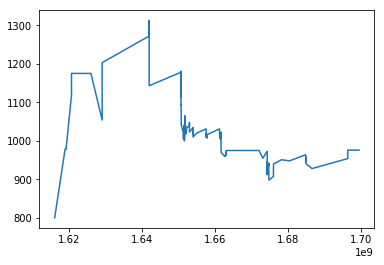

In [293]:
"""
# How has my rating changed over time

time_control = '600'
games = df.query("time_control == '{time_control}'")
print(len(games))
print(games['time_control'].unique())
"""


# Bullet stats
last_bullet_game = datetime.fromtimestamp(player_stats['chess_bullet']['last']['date'])
best_bullet_ranking = datetime.fromtimestamp(player_stats['chess_bullet']['best']['date'])

print(f"Current bullet elo: {player_stats['chess_bullet']['last']['rating']} –– {last_bullet_game}")
print(f"Highest bullet elo: {player_stats['chess_bullet']['best']['rating']} –– {best_bullet_ranking}")
print(f"Record: {player_stats['chess_bullet']['record']['win']}W / {player_stats['chess_bullet']['record']['draw']}D / {player_stats['chess_bullet']['record']['loss']}L")

bullet_games = df.query("time_class == 'bullet'")
bullet_games.head()
bullet_games.sort_values('end_time')

ratings = []
dates = []

for idx, game in bullet_games.iterrows():
    rating = game['w_rating'] if game['w_username'] == username else game['b_rating']
    date = game['end_time']
    ratings.append(rating)
    dates.append(date)

plt.plot(dates, ratings)
plt.show()

Current bullet elo: 1005 –– 2023-09-05 17:22:58
Highest bullet elo: 1111 –– 2023-03-10 01:20:25
Record: 479W / 30D / 439L


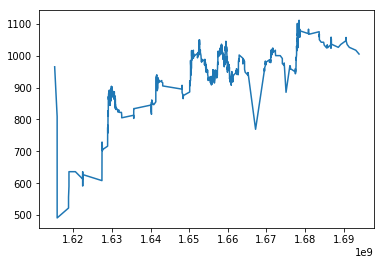

In [297]:
# Blitz stats
last_blitz_game = datetime.fromtimestamp(player_stats['chess_blitz']['last']['date'])
best_blitz_ranking = datetime.fromtimestamp(player_stats['chess_blitz']['best']['date'])

print(f"Current bullet elo: {player_stats['chess_blitz']['last']['rating']} –– {last_blitz_game}")
print(f"Highest bullet elo: {player_stats['chess_blitz']['best']['rating']} –– {best_blitz_ranking}")
print(f"Record: {player_stats['chess_blitz']['record']['win']}W / {player_stats['chess_blitz']['record']['draw']}D / {player_stats['chess_blitz']['record']['loss']}L")

blitz_games = df.query("time_class == 'blitz'")
blitz_games.head()
blitz_games.sort_values('end_time')

ratings = []
dates = []

for idx, game in blitz_games.iterrows():
    rating = game['w_rating'] if game['w_username'] == username else game['b_rating']
    date = game['end_time']
    ratings.append(rating)
    dates.append(date)

plt.plot(dates, ratings)
plt.show()

Current rapid elo: 1561 –– 2023-12-06 23:30:05
Highest rapid elo: 1642 –– 2023-11-30 07:06:17
Record: 2493W / 215D / 2365L


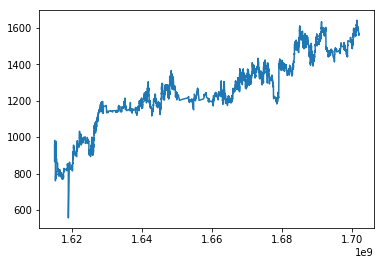

In [296]:
# Rapid stats
last_rapid_game = datetime.fromtimestamp(player_stats['chess_rapid']['last']['date'])
best_rapid_ranking = datetime.fromtimestamp(player_stats['chess_rapid']['best']['date'])

print(f"Current rapid elo: {player_stats['chess_rapid']['last']['rating']} –– {last_rapid_game}")
print(f"Highest rapid elo: {player_stats['chess_rapid']['best']['rating']} –– {best_rapid_ranking}")
print(f"Record: {player_stats['chess_rapid']['record']['win']}W / {player_stats['chess_rapid']['record']['draw']}D / {player_stats['chess_rapid']['record']['loss']}L")

rapid_games = df.query("time_class == 'rapid'")
rapid_games.head()
rapid_games.sort_values('end_time')

ratings = []
dates = []

for idx, game in rapid_games.iterrows():
    rating = game['w_rating'] if game['w_username'] == username else game['b_rating']
    date = game['end_time']
    ratings.append(rating)
    dates.append(date)

plt.plot(dates, ratings)
plt.show()

# Chess daily rankings
# Chess puzzle rankings
# Chess puzzle rush rankings

Current daily elo: 1129 –– 2023-12-03 19:33:10
Highest daily elo: 1129 –– 2023-11-16 21:29:44
Record: 1W / 0D / 0L
[1700198984] [1129]


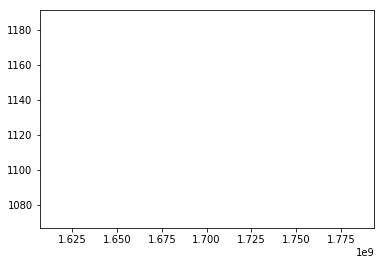

In [299]:
# Daily stats
last_daily_game = datetime.fromtimestamp(player_stats['chess_daily']['last']['date'])
best_daily_ranking = datetime.fromtimestamp(player_stats['chess_daily']['best']['date'])

print(f"Current daily elo: {player_stats['chess_daily']['last']['rating']} –– {last_daily_game}")
print(f"Highest daily elo: {player_stats['chess_daily']['best']['rating']} –– {best_daily_ranking}")
print(f"Record: {player_stats['chess_daily']['record']['win']}W / {player_stats['chess_daily']['record']['draw']}D / {player_stats['chess_daily']['record']['loss']}L")

daily_games = df.query("time_class == 'daily'")
daily_games.head()
daily_games.sort_values('end_time')

ratings = []
dates = []

for idx, game in daily_games.iterrows():
    rating = game['w_rating'] if game['w_username'] == username else game['b_rating']
    date = game['end_time']
    ratings.append(rating)
    dates.append(date)

    print(dates, ratings)

plt.plot(dates, ratings)
plt.show()

In [ ]:
# Chess puzzle rankings
# Chess puzzle rush rankings


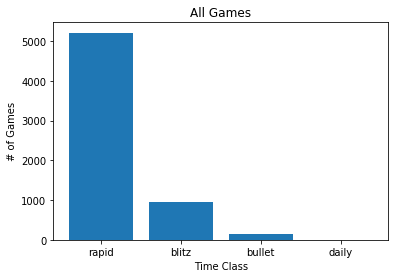

In [267]:
# How many games do I have for each time limit?

x = []
labels = []
for time_class in df['time_class'].unique():
    query_result = df.query(f"time_class == '{time_class}'")
    x.append(len(query_result))
    labels.append(time_class)

plt.bar(labels, x)
plt.xlabel('Time Class')
plt.ylabel('# of Games')
plt.title('All Games')
plt.show()


<class 'str'>


In [ ]:
# Show my 30 most played openings, and sort them as stacked bars for wins losses and draws 
# Show my worst openings and how many times i have played it

In [ ]:
# Track the number of puzzles done each day, and check correlation to games won.  I want to know if doing puzzles increases the changes of me winning games that day
